# Sistem Rekomendasi Produk Supermarket (Saranin.id)

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
%cd drive/MyDrive/Capstone Project

[Errno 2] No such file or directory: 'drive/MyDrive/Capstone Project'
/content/drive/MyDrive/Capstone Project


**Import Library**

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## 1. Data Preparation
Bagian ini memuat proses pembacaan dataset, eksplorasi awal seperti melihat struktur data dengan .head(), informasi tipe data dengan .info(), dan statistik ringkas dengan .describe().

**Load Dataset**


In [60]:
detail = pd.read_csv('detailed_transaction.csv')  # sesuaikan nama file
detail.head()  # lihat 5 data pertama

,id_transaksi,quantity,id_product,harga,total
0,1,5,137,11500.0,57500.0
1,1,4,55,8500.0,34000.0
2,1,4,49,12000.0,48000.0
3,1,5,15,6500.0,32500.0
4,2,5,147,18500.0,92500.0


In [61]:
user = pd.read_csv('user.csv')  # sesuaikan nama file
user.head()  # lihat 5 data pertama

,id_user,fullname,email,gender
0,1,Sibby Cartin,scartin0@google.cn,Female
1,2,Meredith Aven,maven1@marketwatch.com,Male
2,3,Udell Incogna,uincogna2@squarespace.com,Polygender
3,4,Rik Elan,relan3@opera.com,Male
4,5,Sara Ludlam,sludlam4@dell.com,Female


In [62]:
transaksi = pd.read_csv('transaction.csv')  # sesuaikan nama file
transaksi.head()  # lihat 5 data pertama

,id_transaksi,id_user,date
0,1,1,2025-01-01 01:00:00
1,2,2,2025-01-01 02:00:00
2,3,3,2025-01-01 03:00:00
3,4,4,2025-01-01 04:00:00
4,5,5,2025-01-01 05:00:00


In [63]:
produk = pd.read_csv('product.csv')
produk.head()

,id_product,name,category,harga,ketersediaan_stock
0,1,Indomie Goreng,Makanan Instan,3500,True
1,2,Indomie Kuah Ayam Bawang,Makanan Instan,3200,True
2,3,Mie Sedaap Kari Ayam,Makanan Instan,3400,True
3,4,Mie Gelas Ayam Bawang,Makanan Instan,2500,True
4,5,Sarimi Ayam Kecap,Makanan Instan,3000,True


In [64]:
print("=== INFO DATASET: DETAIL TRANSAKSI ===")
detail.info()
print("\n")

print("=== INFO DATASET: TRANSAKSI ===")
transaksi.info()
print("\n")

print("=== INFO DATASET: USER ===")
user.info()
print("\n")

print("=== INFO DATASET: PRODUK ===")
produk.info()

=== INFO DATASET: DETAIL TRANSAKSI ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_transaksi  1000 non-null   int64  
 1   quantity      1000 non-null   int64  
 2   id_product    1000 non-null   int64  
 3   harga         995 non-null    float64
 4   total         995 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 39.2 KB


=== INFO DATASET: TRANSAKSI ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_transaksi  250 non-null    int64 
 1   id_user       250 non-null    int64 
 2   date          250 non-null    object
dtypes: int64(2), object(1)
memory usage: 6.0+ KB


=== INFO DATASET: USER ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data co

In [65]:
print("=== JUMLAH DATASET: DETAIL TRANSAKSI ===")
print(detail.shape) # Changed from detail.shape() to detail.shape
print("\n")

print("=== JUMLAH DATASET: TRANSAKSI ===")
print(transaksi.shape) # Changed from transaksi.shape() to transaksi.shape
print("\n")

print("=== JUMLAH DATASET: USER ===")
print(user.shape) # Changed from user.shape() to user.shape
print("\n")

print("=== JUMLAH DATASET: PRODUK ===")
print(produk.shape) # Changed from produk.shape() to produk.shape

=== JUMLAH DATASET: DETAIL TRANSAKSI ===
(1000, 5)


=== JUMLAH DATASET: TRANSAKSI ===
(250, 3)


=== JUMLAH DATASET: USER ===
(60, 4)


=== JUMLAH DATASET: PRODUK ===
(225, 5)


## 2. Data Preprocessing
Tahapan ini mencakup pembersihan data seperti menghapus nilai kosong, duplikat, serta transformasi data agar siap untuk analisis dan pemodelan.

In [66]:
print("=== Jumlah data duplikat pada dataset Detail Transaksi: ===")
print(detail.duplicated().sum())
print("\n")

print("=== Jumlah data duplikat pada dataset Transaksi: ===")
print(transaksi.duplicated().sum())
print("\n")

print("=== Jumlah data duplikat pada dataset User: ===")
print(user.duplicated().sum())
print("\n")

print("=== Jumlah data duplikat pada dataset Produk: ===")
print(produk.duplicated().sum())

=== Jumlah data duplikat pada dataset Detail Transaksi: ===
2


=== Jumlah data duplikat pada dataset Transaksi: ===
0


=== Jumlah data duplikat pada dataset User: ===
0


=== Jumlah data duplikat pada dataset Produk: ===
0


In [67]:
detail.drop_duplicates(inplace=True)

In [68]:
print("=== Jumlah data duplikat pada dataset Detail Transaksi: ===")
print(detail.duplicated().sum())
print("\n")

=== Jumlah data duplikat pada dataset Detail Transaksi: ===
0




In [69]:
print("=== Jumlah missing values pada dataset Detail Transaksi: ===")
print(detail.isna().sum())
print("\n")

print("=== Jumlah missing values pada dataset Transaksi: ===")
print(transaksi.isna().sum())
print("\n")

print("=== Jumlah missing values pada dataset User: ===")
print(user.isna().sum())
print("\n")

print("=== Jumlah missing values pada dataset Produk: ===")
print(produk.isna().sum())

=== Jumlah missing values pada dataset Detail Transaksi: ===
id_transaksi    0
quantity        0
id_product      0
harga           5
total           5
dtype: int64


=== Jumlah missing values pada dataset Transaksi: ===
id_transaksi    0
id_user         0
date            0
dtype: int64


=== Jumlah missing values pada dataset User: ===
id_user     0
fullname    0
email       0
gender      0
dtype: int64


=== Jumlah missing values pada dataset Produk: ===
id_product            0
name                  0
category              0
harga                 0
ketersediaan_stock    0
dtype: int64


In [70]:
# Imputasi dengan mean untuk kolom numerik
detail['harga'] = detail['harga'].fillna(detail['harga'].mean())
detail['total'] = detail['total'].fillna(detail['total'].mean())

In [71]:
print("=== Jumlah missing values pada dataset Detail Transaksi: ===")
print(detail.isna().sum())
print("\n")

=== Jumlah missing values pada dataset Detail Transaksi: ===
id_transaksi    0
quantity        0
id_product      0
harga           0
total           0
dtype: int64




In [72]:
transaksi.describe(include="all")

,id_transaksi,id_user,date
count,250.000000,250.000000,250
unique,NaN,NaN,250
top,NaN,NaN,2025-01-01 01:00:00
freq,NaN,NaN,1
mean,125.500000,29.500000,NaN
std,72.312977,17.706045,NaN
min,1.000000,1.000000,NaN
25%,63.250000,14.000000,NaN
50%,125.500000,29.000000,NaN
75%,187.750000,45.000000,NaN


In [73]:
transaksi.groupby(by="date").agg({
    "id_user": "nunique",
    "id_transaksi": ["max", "min", "mean", "std"]
})

id_user id_transaksi                
                    nunique          max  min   mean std
date                                                    
2025-01-01 01:00:00       1            1    1    1.0 NaN
2025-01-01 02:00:00       1            2    2    2.0 NaN
2025-01-01 03:00:00       1            3    3    3.0 NaN
2025-01-01 04:00:00       1            4    4    4.0 NaN
2025-01-01 05:00:00       1            5    5    5.0 NaN
...                     ...          ...  ...    ...  ..
2025-01-11 06:00:00       1          246  246  246.0 NaN
2025-01-11 07:00:00       1          247  247  247.0 NaN
2025-01-11 08:00:00       1          248  248  248.0 NaN
2025-01-11 09:00:00       1          249  249  249.0 NaN
2025-01-11 10:00:00       1          250  250  250.0 NaN

[250 rows x 5 columns]

In [74]:
transaksi.groupby(by="date").id_user.nunique().sort_values(ascending=False)

,id_user
date,
2025-01-01 01:00:00,1
2025-01-01 02:00:00,1
2025-01-01 03:00:00,1
2025-01-01 04:00:00,1
2025-01-01 05:00:00,1
...,...
2025-01-11 06:00:00,1
2025-01-11 07:00:00,1
2025-01-11 08:00:00,1


In [75]:
# Gabungkan tabel detail dan transaksi menggunakan left join
merged_df = pd.merge(detail, transaksi, on='id_transaksi', how='left')

# Tampilkan 5 baris pertama dari dataframe yang digabungkan
merged_df.head()

,id_transaksi,quantity,id_product,harga,total,id_user,date
0,1,5,137,11500.0,57500.0,1,2025-01-01 01:00:00
1,1,4,55,8500.0,34000.0,1,2025-01-01 01:00:00
2,1,4,49,12000.0,48000.0,1,2025-01-01 01:00:00
3,1,5,15,6500.0,32500.0,1,2025-01-01 01:00:00
4,2,5,147,18500.0,92500.0,2,2025-01-01 02:00:00


In [76]:
# Tampilkan informasi dataframe yang digabungkan untuk memeriksa tipe data dan missing values
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_transaksi  998 non-null    int64  
 1   quantity      998 non-null    int64  
 2   id_product    998 non-null    int64  
 3   harga         998 non-null    float64
 4   total         998 non-null    float64
 5   id_user       998 non-null    int64  
 6   date          998 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 54.7+ KB


In [77]:
# Gabungkan tabel detail dan transaksi menggunakan left join
merged_produk_df = pd.merge(merged_df, produk, on=['id_product', 'harga'], how='left')

# Tampilkan 5 baris pertama dari dataframe yang digabungkan
merged_produk_df.head()

<ipython-input-77-208142a0bb26>:2: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged_produk_df = pd.merge(merged_df, produk, on=['id_product', 'harga'], how='left')


,id_transaksi,quantity,id_product,harga,total,id_user,date,name,category,ketersediaan_stock
0,1,5,137,11500.0,57500.0,1,2025-01-01 01:00:00,Pepsodent Herbal,Pasta Gigi dan Mouthwash,True
1,1,4,55,8500.0,34000.0,1,2025-01-01 01:00:00,Teh Celup Sariwangi,Kopi dan Teh,True
2,1,4,49,12000.0,48000.0,1,2025-01-01 01:00:00,Torabika Creamy Latte,Kopi dan Teh,True
3,1,5,15,6500.0,32500.0,1,2025-01-01 01:00:00,Mi BonCabe Level 15,Makanan Instan,True
4,2,5,147,18500.0,92500.0,2,2025-01-01 02:00:00,Colgate Total 12 Professional Clean,Pasta Gigi dan Mouthwash,True


In [78]:
# Gabungkan tabel detail dan transaksi menggunakan left join
merged_produk_to_user_df = pd.merge(merged_produk_df, user, on='id_user', how='left')

# Tampilkan 5 baris pertama dari dataframe yang digabungkan
merged_produk_to_user_df.head()

,id_transaksi,quantity,id_product,harga,total,id_user,date,name,category,ketersediaan_stock,fullname,email,gender
0,1,5,137,11500.0,57500.0,1,2025-01-01 01:00:00,Pepsodent Herbal,Pasta Gigi dan Mouthwash,True,Sibby Cartin,scartin0@google.cn,Female
1,1,4,55,8500.0,34000.0,1,2025-01-01 01:00:00,Teh Celup Sariwangi,Kopi dan Teh,True,Sibby Cartin,scartin0@google.cn,Female
2,1,4,49,12000.0,48000.0,1,2025-01-01 01:00:00,Torabika Creamy Latte,Kopi dan Teh,True,Sibby Cartin,scartin0@google.cn,Female
3,1,5,15,6500.0,32500.0,1,2025-01-01 01:00:00,Mi BonCabe Level 15,Makanan Instan,True,Sibby Cartin,scartin0@google.cn,Female
4,2,5,147,18500.0,92500.0,2,2025-01-01 02:00:00,Colgate Total 12 Professional Clean,Pasta Gigi dan Mouthwash,True,Meredith Aven,maven1@marketwatch.com,Male


In [79]:
# Save the final merged DataFrame to a CSV file
merged_produk_to_user_df.to_csv('/content/drive/MyDrive/Capstone Project/supermarket.csv', index=False)

### Visualisasi EDA


In [80]:
Supermarket = pd.read_csv('supermarket.csv')  # sesuaikan nama file
Supermarket.head()  # lihat 5 data pertama

,id_transaksi,quantity,id_product,harga,total,id_user,date,name,category,ketersediaan_stock,fullname,email,gender
0,1,5,137,11500.0,57500.0,1,2025-01-01 01:00:00,Pepsodent Herbal,Pasta Gigi dan Mouthwash,True,Sibby Cartin,scartin0@google.cn,Female
1,1,4,55,8500.0,34000.0,1,2025-01-01 01:00:00,Teh Celup Sariwangi,Kopi dan Teh,True,Sibby Cartin,scartin0@google.cn,Female
2,1,4,49,12000.0,48000.0,1,2025-01-01 01:00:00,Torabika Creamy Latte,Kopi dan Teh,True,Sibby Cartin,scartin0@google.cn,Female
3,1,5,15,6500.0,32500.0,1,2025-01-01 01:00:00,Mi BonCabe Level 15,Makanan Instan,True,Sibby Cartin,scartin0@google.cn,Female
4,2,5,147,18500.0,92500.0,2,2025-01-01 02:00:00,Colgate Total 12 Professional Clean,Pasta Gigi dan Mouthwash,True,Meredith Aven,maven1@marketwatch.com,Male


In [81]:
Supermarket.groupby(by=["category", "name"]).agg({
    "quantity":"sum",
    "total":"sum"
})

quantity  \
category                     name                                             
Alat Kebersihan Rumah        Attack Easy Detergent Bubuk                 14   
                             Bayclin Pembersih Lantai                    26   
                             Daia Detergent Pink                         14   
                             Mama Lemon Jeruk Nipis                      19   
                             Molto Pewangi All Variants                  15   
...                                                                     ...   
Sabun dan Perawatan Tubuh    Sabun Lux Soft Touch                        20   
                             Sabun Nuvo Family Protection                18   
                             Sabun Shinzui Skin Lightening                6   
                             Vaseline Healthy White UV Lightening        14   
Shampoo dan Perawatan Rambut Wardah Hairfall Treatment Shampoo            5   

                                                                      total  
category                     name                                            
Alat Kebersihan Rumah        Attack Easy Detergent Bubuk           322000.0  
                             Bayclin Pembersih Lantai              325000.0  
                             Daia Detergent Pink                   273000.0  
                             Mama Lemon Jeruk Nipis                180500.0  
                             Molto Pewangi All Variants            262500.0  
...                                                                     ...  
Sabun dan Perawatan Tubuh    Sabun Lux Soft Touch                   84000.0  
                             Sabun Nuvo Family Protection           68400.0  
                             Sabun Shinzui Skin Lightening          51000.0  
                             Vaseline Healthy White UV Lightening  413000.0  
Shampoo dan Perawatan Rambut Wardah Hairfall Treatment Shampoo     137500.0  

[208 rows x 2 columns]

In [82]:
Supermarket.groupby(by=["gender", "name"]).agg({
    "quantity":"sum",
    "total":"sum"
})

quantity     total
gender     name                                            
Female     ABC Kopi Susu                        5   42500.0
           Anlene Gold 5X                       1   80000.0
           Antangin JRG                        13   84500.0
           Aqua 1.5L                            5   32500.0
           Astor Wafer Roll Chocolate           1    8500.0
...                                           ...       ...
Polygender Teh Botol Sosro                      1    5000.0
           Twix Chocolate Bar                   5   75000.0
           Ultrajaya Teh Kotak Jasmine          4   24000.0
           Vidoran Xmart 1+ Vanilla             4  220000.0
           Woods Peppermint Cough Syrup         2   43000.0

[473 rows x 2 columns]

In [83]:
Supermarket.groupby(by=["ketersediaan_stock", "name"]).agg({
    "quantity":"sum",
    "total":"sum"
})

quantity     total
ketersediaan_stock name                                                 
True               ABC Kopi Susu                            20  170000.0
                   Anlene Gold 5X                           10  800000.0
                   Antangin JRG                             24  156000.0
                   Aqua 1.5L                                13   84500.0
                   Astor Wafer Roll Chocolate                8   68000.0
...                                                        ...       ...
                   Wardah Hairfall Treatment Shampoo         5  137500.0
                   Wipol Karbol Cemara                       2   27000.0
                   Woods Peppermint Cough Syrup              7  150500.0
                   You C1000 Orange                         14  140000.0
                   Zwitsal Baby Bath Hair dan Body           4  130000.0

[208 rows x 2 columns]

### Encode user_id & product_id

In [84]:
# Inisialisasi LabelEncoder
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

# Encoding kolom 'id_user' dan 'id_product'
Supermarket['user_id_enc'] = user_encoder.fit_transform(Supermarket['id_user'])
Supermarket['product_id_enc'] = product_encoder.fit_transform(Supermarket['id_product'])

# Tampilkan info struktur DataFrame
Supermarket.info()

# Tampilkan 5 baris pertama untuk memastikan hasil encoding
Supermarket[['id_user', 'user_id_enc', 'id_product', 'product_id_enc']].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_transaksi        998 non-null    int64  
 1   quantity            998 non-null    int64  
 2   id_product          998 non-null    int64  
 3   harga               998 non-null    float64
 4   total               998 non-null    float64
 5   id_user             998 non-null    int64  
 6   date                998 non-null    object 
 7   name                993 non-null    object 
 8   category            993 non-null    object 
 9   ketersediaan_stock  993 non-null    object 
 10  fullname            998 non-null    object 
 11  email               998 non-null    object 
 12  gender              998 non-null    object 
 13  user_id_enc         998 non-null    int64  
 14  product_id_enc      998 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 117.1+ K

,id_user,user_id_enc,id_product,product_id_enc
0,1,0,137,121
1,1,0,55,54
2,1,0,49,48
3,1,0,15,14
4,2,1,147,131


**Save to CSV after Encoder**

In [85]:
Supermarket.to_csv('supermarket_encoded.csv', index=False)

**Save Encoder**


In [86]:
import pickle

with open('user_encoder.pkl', 'wb') as f:
    pickle.dump(user_encoder, f)

with open('product_encoder.pkl', 'wb') as f:
    pickle.dump(product_encoder, f)

## 3. Splitting Data
Memisahkan data menjadi data latih dan data uji menggunakan train_test_split, agar model dapat divalidasi performanya.

In [87]:
# Fitur dan target dari data Supermarket
X = Supermarket[['user_id_enc', 'product_id_enc']]
y = Supermarket['quantity']

# Split menjadi data latih dan validasi (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Gabungkan kembali menjadi DataFrame
train_data = X_train.copy()
train_data['quantity'] = y_train

valid_data = X_test.copy()
valid_data['quantity'] = y_test

In [88]:
# Tampilkan jumlah data
print("Jumlah X_train:", len(X_train))
print("Jumlah X_test :", len(X_test))
print("Jumlah y_train:", len(y_train))
print("Jumlah y_test :", len(y_test))
print(f"Train size: {len(train_data)}, Validation size: {len(valid_data)}")

Jumlah X_train: 798
Jumlah X_test : 200
Jumlah y_train: 798
Jumlah y_test : 200
Train size: 798, Validation size: 200


## 4. Modeling - Collaborative Filtering
Menerapkan pendekatan berbasis interaksi pengguna seperti matrix factorization (SVD) atau K-Nearest Neighbors berbasis Surprise.

In [89]:
# Tuning Hyperparameter
embedding_size = 100
dropout_rate = 0.3
l2_reg = 1e-6
learning_rate = 0.0005
batch_size = 256

In [90]:
# Ukuran user dan item unik
num_users = Supermarket['user_id_enc'].nunique()
num_items = Supermarket['product_id_enc'].nunique()

# Input
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# Embedding layer dengan L2 regularizer
user_embedding = Embedding(num_users, embedding_size, embeddings_regularizer=l2(l2_reg))(user_input)
item_embedding = Embedding(num_items, embedding_size, embeddings_regularizer=l2(l2_reg))(item_input)

# Flatten
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

# Gabungkan kedua vektor
concat = Concatenate()([user_vec, item_vec])

# Dropout dan Dense Layer
dropout = Dropout(dropout_rate)(concat)
dense = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(dropout)

# Output
output = Dense(1)(dense)

In [91]:
# Bangun model
model = Model(inputs=[user_input, item_input], outputs=output)

**Compile Model**

In [92]:
# Compile dengan learning rate dari tuning
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='mean_squared_error'
)

In [93]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 100)    │      6,000 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 100)    │     20,900 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 100)       │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 100)       │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 200)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     12,864 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,829 (155.58 KB)

 Trainable params: 39,829 (155.58 KB)

 Non-trainable params: 0 (0.00 B)

**Train Model**

In [94]:
Supermarket.sample(10)

,id_transaksi,quantity,id_product,harga,total,id_user,date,name,category,ketersediaan_stock,fullname,email,gender,user_id_enc,product_id_enc
292,74,3,47,12500.0,37500.0,14,2025-01-04 02:00:00,Good Day Mocacinno,Kopi dan Teh,True,Korry Rothon,krothond@cisco.com,Female,13,46
356,90,5,14,15000.0,75000.0,30,2025-01-04 18:00:00,Mi Samyang Spicy Chicken,Makanan Instan,True,Grete Beverage,gbeveraget@google.ca,Female,29,13
526,133,1,214,9500.0,9500.0,13,2025-01-06 13:00:00,Malkist Roma Cokelat,Camilan Manis,True,Marylinda Witton,mwittonc@angelfire.com,Female,12,197
150,38,2,75,7000.0,14000.0,38,2025-01-02 14:00:00,Dueto Wafer Chocolate,Makanan Ringan,True,Gloriana Westmarland,gwestmarland11@thetimes.co.uk,Female,37,73
621,156,5,88,3500.0,17500.0,36,2025-01-07 12:00:00,Desaku Bumbu Racik Ayam Goreng,Bumbu Dapur,True,Leila Hainey`,lhaineyz@hhs.gov,Female,35,86
851,214,5,93,75000.0,375000.0,34,2025-01-09 22:00:00,Beras Kepala Cap Anak Raja 5kg,Beras dan Bahan Pokok,True,Balduin Bailie,bbailiex@washington.edu,Male,33,91
509,128,1,21,10000.0,10000.0,8,2025-01-06 08:00:00,You C1000 Orange,Minuman,True,Malanie Baughan,mbaughan7@infoseek.co.jp,Female,7,20
875,220,3,118,21000.0,63000.0,40,2025-01-10 04:00:00,Marina UV White Healthy dan Glow,Sabun dan Perawatan Tubuh,True,Roseann Barbera,rbarbera13@un.org,Female,39,116
847,213,1,179,21500.0,21500.0,33,2025-01-09 21:00:00,Woods Peppermint Cough Syrup,Produk Kesehatan,True,Cherrita Edelheid,cedelheidw@soundcloud.com,Female,32,163
592,149,5,146,22500.0,112500.0,29,2025-01-07 05:00:00,Total Care Mouthwash Fresh Mint,Pasta Gigi dan Mouthwash,True,Henrie Inworth,hinworths@shop-pro.jp,Genderfluid,28,130


In [95]:
# EarlyStopping untuk menghentikan training jika val_loss tidak membaik
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

# Training model dengan batch size hasil tuning
history = model.fit(
    [X_train.iloc[:, 0], X_train.iloc[:, 1]],
    y_train,
    validation_data=([X_test.iloc[:, 0], X_test.iloc[:, 1]], y_test),
    epochs=50,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 444ms/step - loss: 11.2549 - val_loss: 10.1143
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 10.8844 - val_loss: 9.9430
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 10.8189 - val_loss: 9.7699
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 10.6391 - val_loss: 9.5911
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 10.3350 - val_loss: 9.4014
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 10.2437 - val_loss: 9.1944
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.9445 - val_loss: 8.9672
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.5854 - val_loss: 8.7110
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.3877 - val_loss: 8.4229
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.0642 - val_loss: 8.0992
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.6722 - val_loss: 7.7367
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.3584 - val_loss: 

**Save & Load Model**

In [96]:
# Save model dalam format HDF5 (.h5)
model.save('supermarket_recommender.h5')
print("Model saved as HDF5: supermarket_recommender.h5")

Model saved as HDF5: supermarket_recommender.h5


In [97]:
# Save model dalam format Keras (.keras)
model.save('supermarket_recommender.keras')
print("Model saved as Keras format: supermarket_recommender.keras")

Model saved as Keras format: supermarket_recommender.keras


In [98]:
# Load model dari file .keras
loaded_model = load_model('supermarket_recommender.keras')
print("Model loaded successfully from supermarket_recommender.keras")

Model loaded successfully from supermarket_recommender.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 5. Modeling - Content Based Filtering
Membangun sistem rekomendasi berbasis kemiripan konten menggunakan metode seperti cosine similarity atau linear kernel.

**Preprocessing untuk Content-Based Filtering**


In [99]:
# --- Ambil data produk unik ---
products = Supermarket[['product_id_enc', 'name', 'category']].drop_duplicates().reset_index(drop=True)

def preprocess_text(text):
    return str(text).lower().strip()

# Terapkan preprocessing
products['name'] = products['name'].fillna('').apply(preprocess_text)
products['category'] = products['category'].fillna('').apply(preprocess_text)

# Gabungkan fitur teks
products['combined_features'] = products['name'] + ' ' + products['category']

# TF-IDF Vectorizer & Cosine Similarity
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(products['combined_features'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Mapping product_id ke index baris
product_indices = pd.Series(products.index, index=products['product_id_enc']).to_dict()

**Save Model**

In [100]:
# --- Simpan Model Content-Based ---
import pickle
with open('content_based_model.pkl', 'wb') as f:
    pickle.dump((products, cosine_sim, product_indices), f)

# --- Muat Model ---
try:
    with open('content_based_model.pkl', 'rb') as f:
        loaded_products, loaded_cosine_sim, loaded_product_indices = pickle.load(f)

    print("✅ Model berhasil dimuat!\n")
    print("📝 Contoh Produk:")
    display(loaded_products.head())

    print("\n📐 Ukuran matriks similarity:", loaded_cosine_sim.shape)
    print("🧮 Total product indices:", len(loaded_product_indices))

    # --- Tambahan: Preview TF-IDF Matrix ---
    print("\n🔢 Ukuran TF-IDF Matrix:", tfidf_matrix.shape)
    tfidf_df = pd.DataFrame(tfidf_matrix[:5].toarray(), columns=tfidf.get_feature_names_out())
    print("📄 Contoh isi TF-IDF Matrix (5 produk pertama):")
    display(tfidf_df)

    # --- Tambahan: Preview Cosine Similarity Matrix ---
    cosine_df = pd.DataFrame(loaded_cosine_sim[:5, :5],
                             columns=[f"Produk_{i}" for i in range(5)],
                             index=[f"Produk_{i}" for i in range(5)])
    print("📊 Contoh Cosine Similarity antar 5 produk pertama:")
    display(cosine_df)

    # --- Tambahan: Buat DataFrame Similarity Produk Top-N ---
    top_n = 3
    print(f"\n📌 Tabel kemiripan Top {top_n} produk pertama:")
    for i in range(top_n):
        idx = i
        similar_indices = cosine_sim[idx].argsort()[::-1][1:top_n+1]  # top N selain dirinya
        similar_scores = cosine_sim[idx][similar_indices]
        similar_products = products.iloc[similar_indices][['product_id_enc', 'name', 'category']].copy()
        similar_products['similarity_score'] = similar_scores
        print(f"\n🔍 Produk: {products.iloc[idx]['name']} ({products.iloc[idx]['category']})")
        display(similar_products)

except FileNotFoundError:
    print("❌ File model tidak ditemukan.")
except Exception as e:
    print(f"❌ Terjadi error saat memuat model: {e}")

✅ Model berhasil dimuat!

📝 Contoh Produk:


,product_id_enc,name,category,combined_features
0,121,pepsodent herbal,pasta gigi dan mouthwash,pepsodent herbal pasta gigi dan mouthwash
1,54,teh celup sariwangi,kopi dan teh,teh celup sariwangi kopi dan teh
2,48,torabika creamy latte,kopi dan teh,torabika creamy latte kopi dan teh
3,14,mi boncabe level 15,makanan instan,mi boncabe level 15 makanan instan
4,131,colgate total 12 professional clean,pasta gigi dan mouthwash,colgate total 12 professional clean pasta gigi...



📐 Ukuran matriks similarity: (209, 209)
🧮 Total product indices: 209

🔢 Ukuran TF-IDF Matrix: (209, 473)
📄 Contoh isi TF-IDF Matrix (5 produk pertama):


,10,100,100g,12,15,1kg,1l,250ml,2l,360ml,...,wardah,wash,white,whitening,wing,wipol,woods,xmart,zee,zwitsal
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.494175,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.408916,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


📊 Contoh Cosine Similarity antar 5 produk pertama:


,Produk_0,Produk_1,Produk_2,Produk_3,Produk_4
Produk_0,1.000000,0.043428,0.042822,0.0,0.312333
Produk_1,0.043428,1.000000,0.335289,0.0,0.031361
Produk_2,0.042822,0.335289,1.000000,0.0,0.030923
Produk_3,0.000000,0.000000,0.000000,1.0,0.000000
Produk_4,0.312333,0.031361,0.030923,0.0,1.000000



📌 Tabel kemiripan Top 3 produk pertama:

🔍 Produk: pepsodent herbal (pasta gigi dan mouthwash)


,product_id_enc,name,category,similarity_score
194,120,pepsodent whitening,pasta gigi dan mouthwash,0.694937
141,134,pepsodent mouthwash active defense,pasta gigi dan mouthwash,0.618405
163,129,betadine mouthwash dan gargle,pasta gigi dan mouthwash,0.487658



🔍 Produk: teh celup sariwangi (kopi dan teh)


,product_id_enc,name,category,similarity_score
97,55,teh sosro celup melati,kopi dan teh,0.673043
185,57,tong tji teh celup,kopi dan teh,0.656759
166,49,abc kopi susu,kopi dan teh,0.481579



🔍 Produk: torabika creamy latte (kopi dan teh)


,product_id_enc,name,category,similarity_score
166,49,abc kopi susu,kopi dan teh,0.370246
1,54,teh celup sariwangi,kopi dan teh,0.335289
47,52,kopi tubruk gadjah,kopi dan teh,0.328967


## 6. Evaluation - Collaborative Filtering
Mengevaluasi performa model menggunakan metrik seperti Hit Ratio@K, precision, recall, atau skor validasi silang.

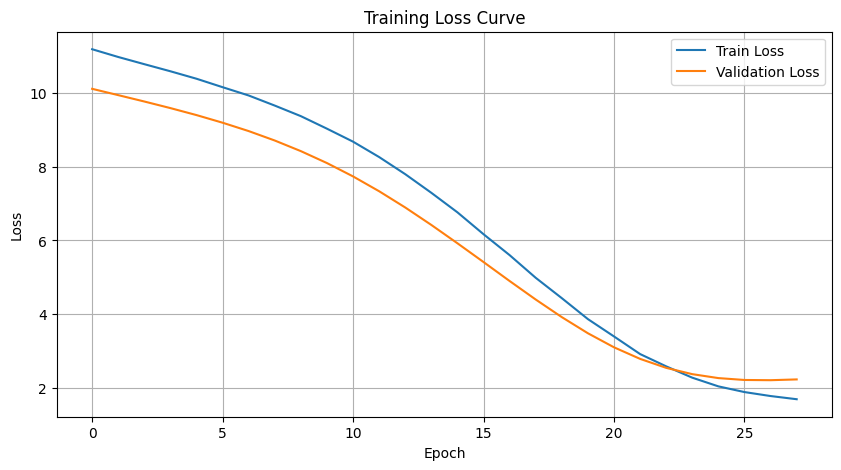

In [101]:
# --- Plot Loss Curve ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [102]:
# --- Hitung MSE pada Validasi ---
user_input = valid_data['user_id_enc'].values
product_input = valid_data['product_id_enc'].values
y_true = valid_data['quantity'].values

y_pred = loaded_model.predict([user_input, product_input]).flatten()
mse = mean_squared_error(y_true, y_pred)
print(f"📉 Mean Squared Error (MSE) pada validasi: {mse:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
📉 Mean Squared Error (MSE) pada validasi: 2.2066


In [103]:
# Tampilkan sampel data pengguna
print("Contoh data transaksi:")
display(Supermarket.sample(5))

Contoh data transaksi:


,id_transaksi,quantity,id_product,harga,total,id_user,date,name,category,ketersediaan_stock,fullname,email,gender,user_id_enc,product_id_enc
30,8,1,211,25000.0,25000.0,8,2025-01-01 08:00:00,SilverQueen Cashew Milk Chocolate,Camilan Manis,True,Malanie Baughan,mbaughan7@infoseek.co.jp,Female,7,195
904,227,1,48,23000.0,23000.0,47,2025-01-10 11:00:00,Nescafe Classic 100g,Kopi dan Teh,True,Barrett Godbolt,bgodbolt1a@gravatar.com,Genderqueer,46,47
42,11,2,171,21500.0,43000.0,11,2025-01-01 11:00:00,Minyak Kayu Putih Cap Lang,Produk Kesehatan,True,Noelyn Leggate,nleggatea@naver.com,Female,10,155
988,248,4,184,17500.0,70000.0,8,2025-01-11 08:00:00,Molto Pewangi All Variants,Alat Kebersihan Rumah,True,Malanie Baughan,mbaughan7@infoseek.co.jp,Female,7,168
970,244,3,180,18000.0,54000.0,4,2025-01-11 04:00:00,OBH Combi Anak,Produk Kesehatan,True,Rik Elan,relan3@opera.com,Male,3,164


## 7. Recommendation Examples - Collaborative Filtering
Menampilkan contoh hasil rekomendasi untuk pengguna tertentu berdasarkan model yang telah dilatih.

In [104]:
# Ambil 1 user untuk prediksi
target_user_raw = Supermarket['id_user'].iloc[0]
target_user = user_encoder.transform([target_user_raw])[0]

# Ambil produk yang sudah pernah dibeli user
rated_products = Supermarket[Supermarket['user_id_enc'] == target_user]['product_id_enc'].tolist()

# Buat daftar produk yang belum dibeli
all_products = np.arange(num_items)
unrated_products = np.setdiff1d(all_products, rated_products)

# Buat array user sebanyak jumlah produk yang belum dibeli
user_array = np.full(len(unrated_products), target_user)

# Prediksi rating/kuantitas
pred_ratings = loaded_model.predict([user_array, unrated_products]).flatten()

# Buat DataFrame hasil rekomendasi
results = pd.DataFrame({
    'product_id_enc': unrated_products,
    'trusted_score': pred_ratings,
})

# Kembalikan ID produk asli
results['id_product'] = product_encoder.inverse_transform(results['product_id_enc'])

# Gabungkan dengan nama produk & kategori
results = results.merge(
    Supermarket[['id_product', 'name', 'category']].drop_duplicates(),
    on='id_product',
    how='left'
)

# Ambil 10 rekomendasi teratas
top_recommendations = results.sort_values('trusted_score', ascending=False).head(15)

# Tampilkan hasil
print(f"\nTop 15 rekomendasi untuk user {target_user_raw}:")
# Display the relevant columns, trusted_score is available
display(top_recommendations[['id_product', 'name', 'category', 'trusted_score']])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Top 15 rekomendasi untuk user 1:


,id_product,name,category,trusted_score
117,146,Total Care Mouthwash Fresh Mint,Pasta Gigi dan Mouthwash,3.691935
92,106,Sabun Lifebuoy Total 10,Sabun dan Perawatan Tubuh,3.572874
179,213,Choki-Choki Stick,Camilan Manis,3.549049
156,188,Vixal Pembersih Kamar Mandi,Alat Kebersihan Rumah,3.503601
101,115,Body Wash Scarlett Brightening Pomegranate,Sabun dan Perawatan Tubuh,3.489702
188,222,Nabati Wafer Chocolate,Camilan Manis,3.480892
51,61,Chitato Sapi Panggang,Makanan Ringan,3.477882
42,50,ABC Kopi Susu,Kopi dan Teh,3.426202
59,69,Oreo Vanilla,Makanan Ringan,3.420055
70,81,Masako Rasa Sapi,Bumbu Dapur,3.417077


## 8. Evaluation - Content Based Filtering
Mengevaluasi performa model menggunakan metrik seperti Hit Ratio@K, precision, recall, atau skor validasi silang.

In [105]:
def recommend_content_based(user_id, data, top_n=5):
    user_products = data[data['user_id_enc'] == user_id]['product_id_enc'].unique()
    scores = {}

    for pid in user_products:
        idx = product_indices.get(pid)
        if idx is not None:
            sim_scores = list(enumerate(cosine_sim[idx]))
            for i, score in sim_scores:
                pid_similar = products.iloc[i]['product_id_enc']
                if pid_similar not in user_products:
                    scores[pid_similar] = scores.get(pid_similar, 0) + score

    recommended_ids = sorted(scores, key=scores.get, reverse=True)[:top_n]

    recommended_products = products.set_index('product_id_enc').loc[recommended_ids].reset_index()
    recommended_products['trusted_score'] = recommended_products['product_id_enc'].map(scores)
    recommended_products = recommended_products.sort_values(by='trusted_score', ascending=False).reset_index(drop=True)

    return recommended_products[['product_id_enc', 'name', 'category', 'trusted_score']]

In [106]:
def evaluate_user_metrics(user_id, train_data, valid_data, k=5):
    # Produk yang direkomendasikan berdasarkan train_data
    recommended_df = recommend_content_based(user_id, train_data, top_n=k)

    if recommended_df is None or recommended_df.empty:
        return None

    recommended = set(recommended_df['product_id_enc'].values)

    # Produk ground truth dari valid_data
    relevant = set(valid_data[valid_data['user_id_enc'] == user_id]['product_id_enc'].unique())

    if not relevant:
        return None

    true_positive = len(recommended & relevant)
    precision = true_positive / k
    recall = true_positive / len(relevant)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    hit = 1 if true_positive > 0 else 0

    return precision, recall, f1, hit

In [107]:
precision_scores = []
recall_scores = []
f1_scores = []
hit_scores = []

user_ids = valid_data['user_id_enc'].unique()

for uid in user_ids:
    result = evaluate_user_metrics(uid, train_data, valid_data, k=5)
    if result:
        p, r, f1, hit = result
        precision_scores.append(p)
        recall_scores.append(r)
        f1_scores.append(f1)
        hit_scores.append(hit)

In [108]:
# Rata-rata metrik
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)
avg_hit_ratio = sum(hit_scores) / len(hit_scores)

print(f"📊 Total User Dievaluasi (validasi): {len(precision_scores)}")
print(f"🎯 Rata-rata Precision@5: {avg_precision:.2f}")
print(f"🔁 Rata-rata Recall@5: {avg_recall:.2f}")
print(f"⚖️  Rata-rata F1-Score@5: {avg_f1:.2f}")
print(f"💡 Hit Ratio@5: {avg_hit_ratio:.2f}")

📊 Total User Dievaluasi (validasi): 57
🎯 Rata-rata Precision@5: 0.02
🔁 Rata-rata Recall@5: 0.02
⚖️  Rata-rata F1-Score@5: 0.02
💡 Hit Ratio@5: 0.09


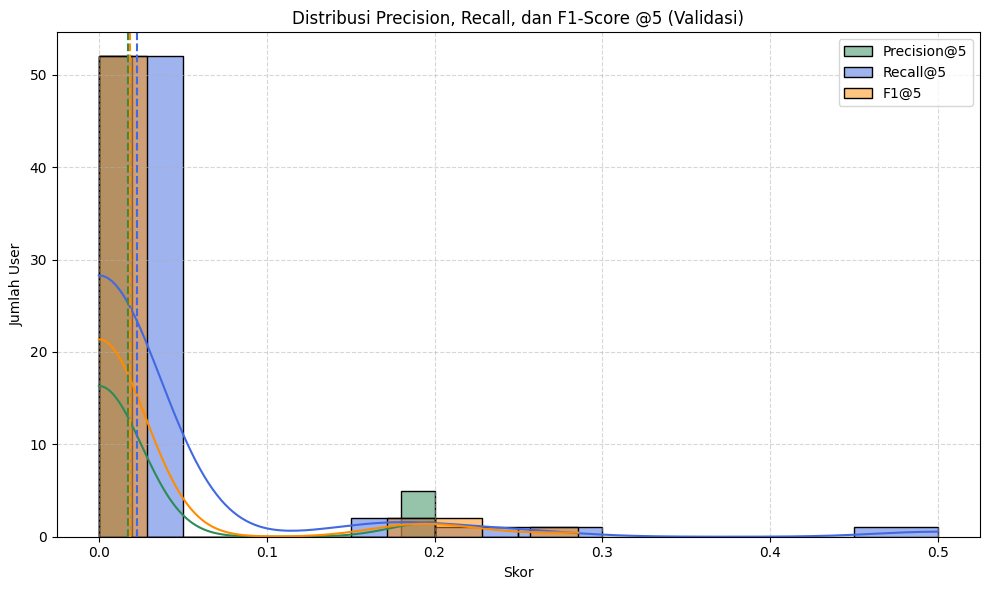

In [109]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(precision_scores, kde=True, label='Precision@5', color='seagreen', bins=10)
sns.histplot(recall_scores, kde=True, label='Recall@5', color='royalblue', bins=10)
sns.histplot(f1_scores, kde=True, label='F1@5', color='darkorange', bins=10)
plt.axvline(avg_precision, color='seagreen', linestyle='--')
plt.axvline(avg_recall, color='royalblue', linestyle='--')
plt.axvline(avg_f1, color='darkorange', linestyle='--')
plt.title("Distribusi Precision, Recall, dan F1-Score @5 (Validasi)")
plt.xlabel("Skor")
plt.ylabel("Jumlah User")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

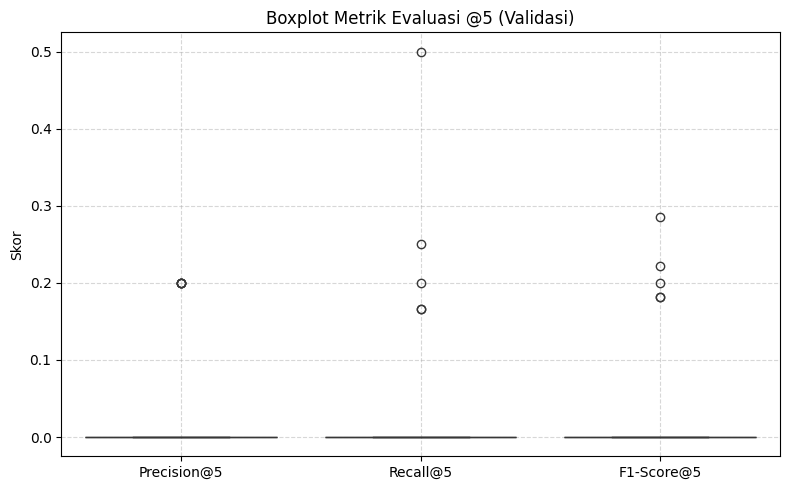

In [110]:
# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=[precision_scores, recall_scores, f1_scores],
            palette=['seagreen', 'royalblue', 'darkorange'])
plt.xticks([0, 1, 2], ['Precision@5', 'Recall@5', 'F1-Score@5'])
plt.title("Boxplot Metrik Evaluasi @5 (Validasi)")
plt.ylabel("Skor")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 9. Recommendation Examples - Content Based Filtering
Deskripsi: Menampilkan contoh hasil rekomendasi untuk pengguna tertentu berdasarkan model yang telah dilatih.

In [111]:
# --- Contoh Rekomendasi ---
user_ids = Supermarket['user_id_enc'].unique()
sample_user_id = user_ids[0]

# Ubah kembali ke user_id asli
raw_user_id = user_encoder.inverse_transform([sample_user_id])[0]

print(f"\n🔍 Contoh Rekomendasi untuk User ID: {raw_user_id}")
recommendation = recommend_content_based(sample_user_id, Supermarket, top_n=15)

if recommendation is not None and not recommendation.empty:
    display(recommendation[['product_id_enc', 'name', 'category', 'trusted_score']])
else:
    print("⚠️ Tidak ada rekomendasi ditemukan untuk user ini.")


🔍 Contoh Rekomendasi untuk User ID: 1


,product_id_enc,name,category,trusted_score
0,55,teh sosro celup melati,kopi dan teh,2.108914
1,49,abc kopi susu,kopi dan teh,1.917778
2,56,teh pucuk harum jasmine,kopi dan teh,1.904733
3,46,good day mocacinno,kopi dan teh,1.750204
4,52,kopi tubruk gadjah,kopi dan teh,1.606265
5,58,sosro heritage green tea,kopi dan teh,1.597128
6,51,kopiko lucky day,kopi dan teh,1.491923
7,53,starbucks via colombia,kopi dan teh,1.445175
8,50,luwak white koffie original,kopi dan teh,1.380322
9,45,kopi kapal api special mix,kopi dan teh,1.333189


## 10. Conclusion
Menyimpulkan hasil dari sistem rekomendasi. Bagian ini bisa menyebutkan:
- Model mana yang memberikan hasil terbaik.
- Produk apa yang sering direkomendasikan.
- Insight bisnis seperti potensi upsell atau produk populer.

